# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Necessary Library

In [2]:
import os
import zipfile
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

# Extracting ZIP File Dataset

In [ ]:
# Specify the path to your zip file
zip_file_path = '/content/drive/MyDrive/dataset/Flower_Disease.v1i.yolov8.zip'  # Replace with your zip file path

# Specify the directory where you want to extract the contents
extract_dir = '/content/drive/MyDrive/dataset/Flower_Disease'  # Replace with your desired extraction directory

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")

Files extracted to: /content/drive/MyDrive/dataset/Flower_Disease


# Data Augmentation

In [26]:
# Define the data generators for training, validation, and testing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 5

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Specify the directories for training, validation, and testing images
train_dir = '/content/drive/MyDrive/dataset/Plagues/train'  # Replace with your train directory
valid_dir = '/content/drive/MyDrive/dataset/Plagues/valid'  # Replace with your valid directory
test_dir = '/content/drive/MyDrive/dataset/Plagues/test'   # Replace with your test directory

# Generate batches of augmented images for training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(640, 640),  # Adjust the target size as needed
    batch_size=batch_size,
    class_mode='categorical',  # or 'binary' depending on your task
    repeat=True
)

# Generate batches of images for validation
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(640, 640),
    batch_size=batch_size,
    class_mode='categorical',
    repeat=True
)

# Generate batches of images for testing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(640, 640),
    batch_size=batch_size,
    class_mode='categorical',

)

num_classes_train = train_generator.num_classes
num_classes_valid = valid_generator.num_classes
num_classes_test = test_generator.num_classes

print(f"Number of classes in train_generator: {num_classes_train}")
print(f"Number of classes in valid_generator: {num_classes_valid}")
print(f"Number of classes in test_generator: {num_classes_test}")

TypeError: ImageDataGenerator.flow_from_directory() got an unexpected keyword argument 'repeat'

# Creating the Model

## Using Transfer Learning (MobileNetV2)

In [32]:
from tensorflow.keras.applications import MobileNetV2

# Load the pre-trained model without the classification layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(640, 640, 3))

# Freeze the base model layers to prevent them from being updated during training
base_model.trainable = False

# Create a new model on top of the base model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

<ipython-input-32-262211816ce4>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(640, 640, 3))


## Using Raw CNN

In [19]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(640, 640, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(3, activation='softmax')
])


optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 638, 638, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 319, 319, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 317, 317, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 158, 158, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 156, 156, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 156, 156, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 78, 78, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 76, 76, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 38, 38, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 36, 36, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 18, 18, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 165888)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      21,233,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,802,755 (86.99 MB)

 Trainable params: 22,802,755 (86.99 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

In [ ]:
epochs = 100

In [33]:
# Compile and train the model

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator)

Epoch 1/100


ValueError: Unknown variable: <KerasVariable shape=(1280, 128), dtype=float32, path=sequential_5/dense_10/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

## Early Stopping Callback

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator
)

# Evaluating the Model

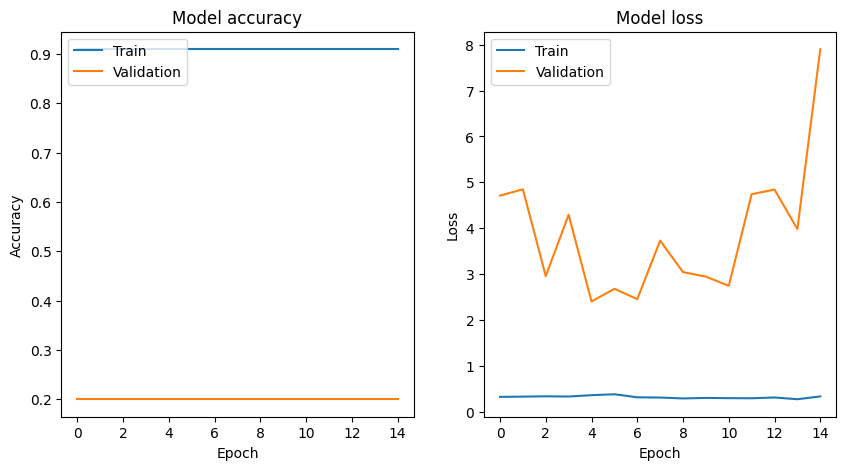

In [29]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()